Start training the model...
Training the final model...

Plotting the training process curve...


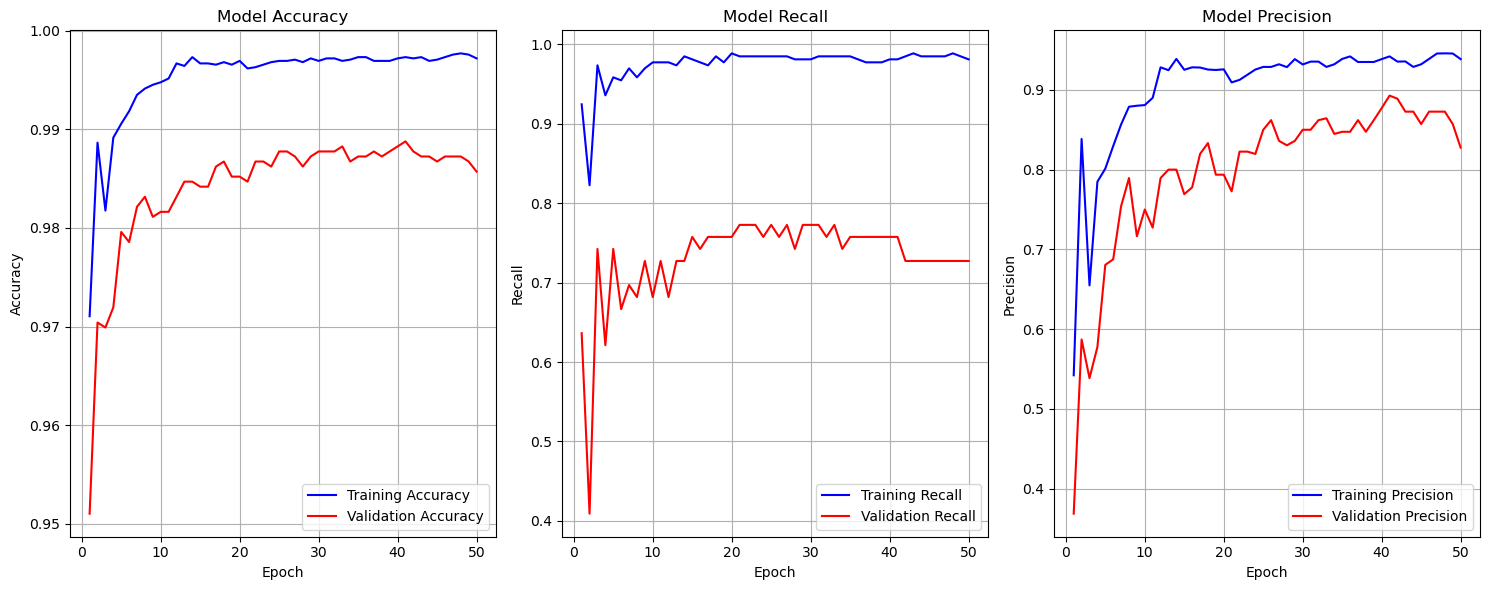


Perform detailed modeling assessments...

=== Basic Performance Indicators ===

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1894
           1       0.83      0.73      0.77        66

    accuracy                           0.99      1960
   macro avg       0.91      0.86      0.88      1960
weighted avg       0.99      0.99      0.99      1960


=== Detailed error analysis ===
True Positives: 48
False Positives: 10
True Negatives) 1884
False Negatives: 18

False Detection Rate: 0.0053
Miss Rate: 0.2727
Precision: 0.8276

=== AUC ===
ROC AUC: 0.9717
PR AUC: 0.8538

=== Ranking of feature importance ===
                   feature  importance
2   Rotational speed [rpm]    0.249722
3              Torque [Nm]    0.200527
4          Tool wear [min]    0.185341
7           power_estimate    0.174477
6          temp_difference    0.085540
8                wear_rate    0.039299
0      Air temperature

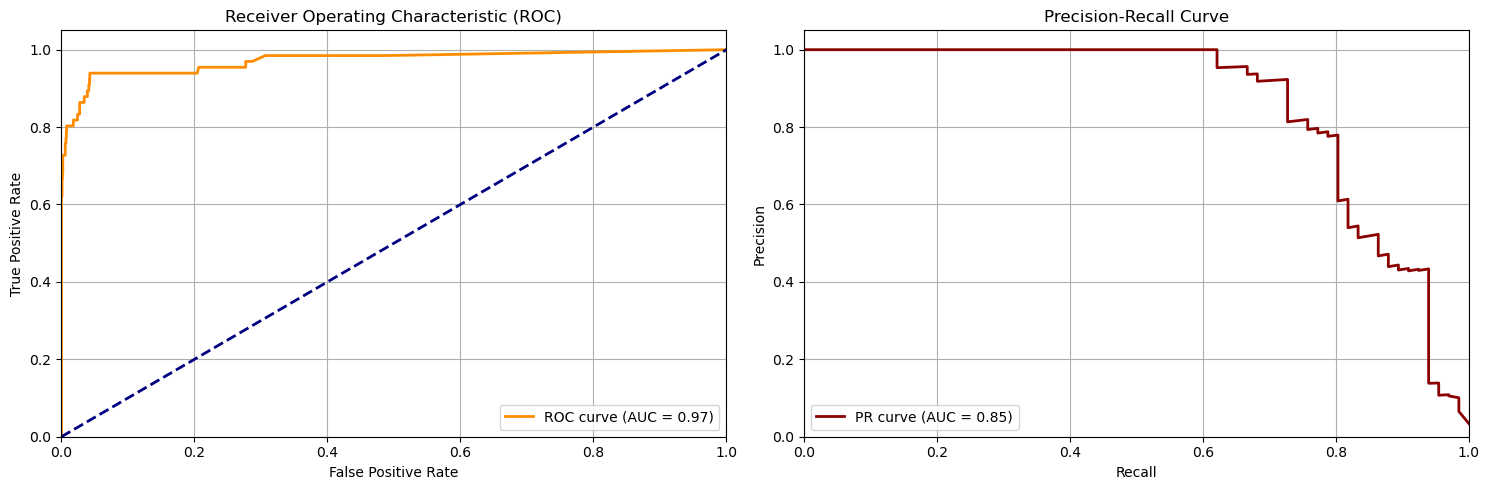

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, learning_curve
import joblib

# 2. 加载数据
X_train = pd.read_csv('../data/processed_data/X_train.csv')
X_test = pd.read_csv('../data/processed_data/X_test.csv')
y_train = pd.read_csv('../data/processed_data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed_data/y_test.csv').values.ravel()

# 3. Historical performance tracking function 
class ModelTracker:
    def __init__(self):
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_recall = []
        self.val_recall = []
        self.train_precision = []
        self.val_precision = []
        self.epochs = []
    
    def update(self, model, X_train, X_test, y_train, y_test, epoch):
        # Calculate the performance of training set 
        train_pred = model.predict(X_train)
        self.train_accuracy.append(model.score(X_train, y_train))
        self.train_recall.append(recall_score(y_train, train_pred))
        self.train_precision.append(precision_score(y_train, train_pred))
        
        # Calculate the performance of validation set 
        val_pred = model.predict(X_test)
        self.val_accuracy.append(model.score(X_test, y_test))
        self.val_recall.append(recall_score(y_test, val_pred))
        self.val_precision.append(precision_score(y_test, val_pred))
        
        self.epochs.append(epoch)

    def plot_training_curves(self):
        plt.figure(figsize=(15, 6))
        
        # Accuracy curve
        plt.subplot(1, 3, 1)
        plt.plot(self.epochs, self.train_accuracy, 'b-', label='Training Accuracy')
        plt.plot(self.epochs, self.val_accuracy, 'r-', label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        
        #Recall curve
        plt.subplot(1, 3, 2)
        plt.plot(self.epochs, self.train_recall, 'b-', label='Training Recall')
        plt.plot(self.epochs, self.val_recall, 'r-', label='Validation Recall')
        plt.title('Model Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.grid(True)
        plt.legend()
        
        # Precision
        plt.subplot(1, 3, 3)
        plt.plot(self.epochs, self.train_precision, 'b-', label='Training Precision')
        plt.plot(self.epochs, self.val_precision, 'r-', label='Validation Precision')
        plt.title('Model Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Performance evaluation functiom
def detailed_evaluation(model, X_train, X_test, y_train, y_test):
    # Predictive value and probability
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    test_prob = model.predict_proba(X_test)
    
    # Basic Performance Indicators
    print("\n=== Basic Performance Indicators ===")
    print("\nTesting Set Classification Report:")
    print(classification_report(y_test, test_pred))
    
    cm = confusion_matrix(y_test, test_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\n=== Detailed error analysis ===")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives) {tn}")
    print(f"False Negatives: {fn}")
    print(f"\nFalse Detection Rate: {fp/(fp+tn):.4f}")
    print(f"Miss Rate: {fn/(fn+tp):.4f}")
    print(f"Precision: {tp/(tp+fp):.4f}")
    
    # Generate data of OC and PR curve
    fpr, tpr, _ = roc_curve(y_test, test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, test_prob[:, 1])
    pr_auc = auc(recall, precision)
    
    print("\n=== AUC ===")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    print("\n=== Ranking of feature importance ===")
    feature_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(feature_imp)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print("\n=== cross-validation ===")
    print(f"cross-validated average score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Plotting ROC and PR curves
    plt.figure(figsize=(15, 5))
    
    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='darkred', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'feature_importance': feature_imp
    }

# Initialize models and trackers
tracker = ModelTracker()
rf_model = RandomForestClassifier(
    # number of tree
    n_estimators=50,  
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Start training the model...")
for i in range(1, rf_model.n_estimators + 1):
    temp_model = RandomForestClassifier(
        n_estimators=i,
        max_depth=rf_model.max_depth,
        min_samples_split=rf_model.min_samples_split,
        min_samples_leaf=rf_model.min_samples_leaf,
        max_features=rf_model.max_features,
        class_weight=rf_model.class_weight,
        random_state=rf_model.random_state
    )
    temp_model.fit(X_train, y_train)
    tracker.update(temp_model, X_train, X_test, y_train, y_test, i)

print("Training the final model...")
rf_model.fit(X_train, y_train)

print("\nPlotting the training process curve...")
tracker.plot_training_curves()

print("\nPerform detailed modeling assessments...")
evaluation_results = detailed_evaluation(rf_model, X_train, X_test, y_train, y_test)

# model_path = '../models/random_forest_model.joblib'
# results_path = '../models/evaluation_results.joblib'
# joblib.dump(rf_model, model_path)
# joblib.dump(evaluation_results, results_path)
# # """